<a href="https://colab.research.google.com/github/simran487/Twitter-Sentiment-Analysis-using-Fine-Tuned-LSTM-Model/blob/main/semIV_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding, Flatten


from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv/train.csv', encoding='latin1')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv', encoding='latin1')

In [ ]:
combined_df = pd.concat([train_df, test_df])

In [ ]:
combined_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


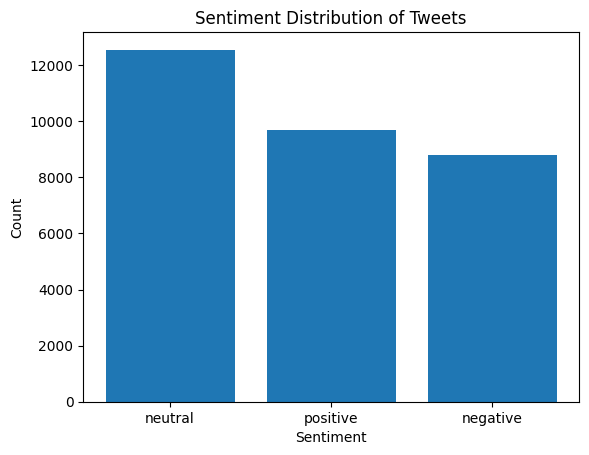

In [ ]:
sentiment_counts = combined_df['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution of Tweets')
plt.show()

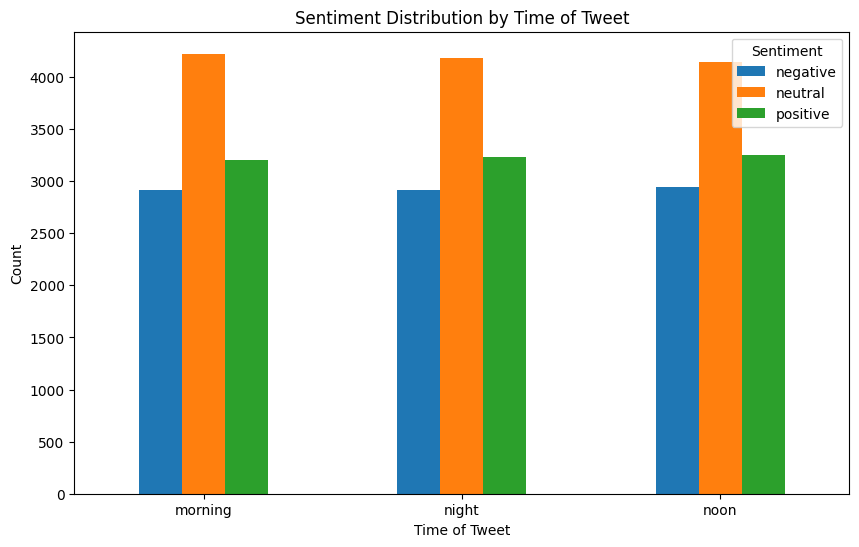

In [ ]:
sentiment_by_time = combined_df.groupby('Time of Tweet')['sentiment'].value_counts().unstack(fill_value=0)
sentiment_by_time.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Time of Tweet')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Time of Tweet')
plt.legend(title='Sentiment')
plt.xticks(rotation=0)
plt.show()

In [ ]:
import networkx as nx
# Network Analysis
# Construct a network graph from retweets or mentions
G = nx.DiGraph()
for _, row in combined_df.iterrows():
    user = str(row['textID'])  # Convert to string to handle float values
    mentions = str(row['text']).split(',')  # Convert to string and split
    for mention in mentions:
        G.add_edge(user, mention.strip())  # Remove leading/trailing whitespaces

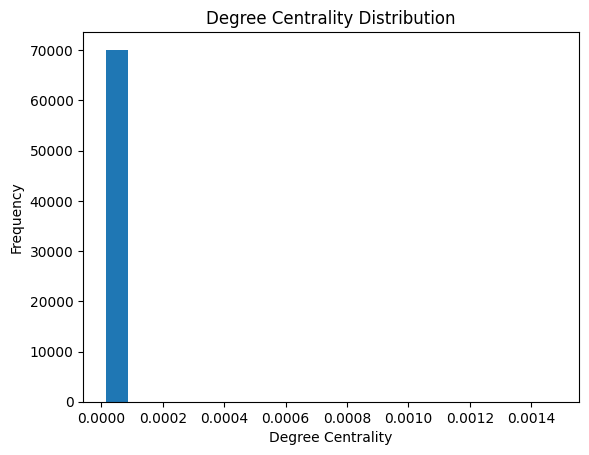

In [ ]:
# Calculate network metrics
degree_centrality = nx.degree_centrality(G)
# Plot degree centrality distribution
plt.hist(degree_centrality.values(), bins=20)
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Degree Centrality Distribution')
plt.show()


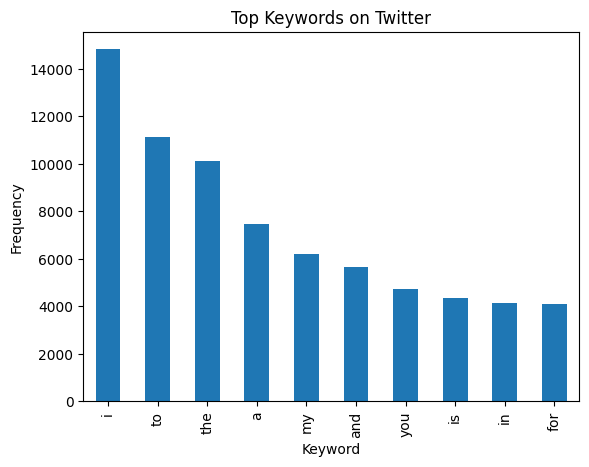

In [ ]:
# Content Analysis
# Analyze the frequency of keywords or hashtags
keywords = combined_df['text'].str.lower().str.split().explode().value_counts()
top_keywords = keywords.head(10)
top_keywords.plot(kind='bar')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.title('Top Keywords on Twitter')
plt.show()

In [ ]:
#What emotional landscapes are painted by Twitter users from different political spectrums?
from nltk.sentiment.vader import SentimentIntensityAnalyzer
twitter_data = pd.DataFrame()
twitter_data['text'] = combined_df['text'].astype(str)

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis on each tweet and store the results
sentiments = []
for tweet in twitter_data['text']:
    sentiment = sid.polarity_scores(tweet)
    sentiments.append(sentiment)

# Convert the sentiment scores to a DataFrame
sentiments_df = pd.DataFrame(sentiments)

# Merge the sentiment scores with the original DataFrame
# twitter_data_with_sentiment = pd.concat([twitter_data, sentiments_df], axis=1)
# Now it can be analyzed sentiment distributions and compare across different political spectrums

In [ ]:
sentiments_df.head()

,neg,neu,pos,compound
0,0.000,1.000,0.0,0.0000
1,0.474,0.526,0.0,-0.7437
2,0.494,0.506,0.0,-0.5994
3,0.538,0.462,0.0,-0.3595
4,0.000,1.000,0.0,0.0000


In [ ]:
#How do these emotional hues blend with the framing strategies?
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import string

In [ ]:
twitter_data = combined_df


In [ ]:
# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    # Check if text is NaN
    if isinstance(text, float):
        return ''
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize text using spaCy
    doc = nlp(text)
    # Lemmatize words using spaCy
    tokens = [token.lemma_ for token in doc]
    # Remove stopwords
    tokens = [token for token in tokens if not nlp.vocab[token].is_stop]
    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [ ]:
twitter_data['preprocessed_text'] = twitter_data['text'].apply(preprocess_text)



In [ ]:
# Function to calculate sentiment scores
def calculate_sentiment_score(text):
    sentiment_score = sid.polarity_scores(text)['compound']
    return sentiment_score

# Apply sentiment analysis to preprocessed text
twitter_data['sentiment_score'] = twitter_data['preprocessed_text'].apply(calculate_sentiment_score)


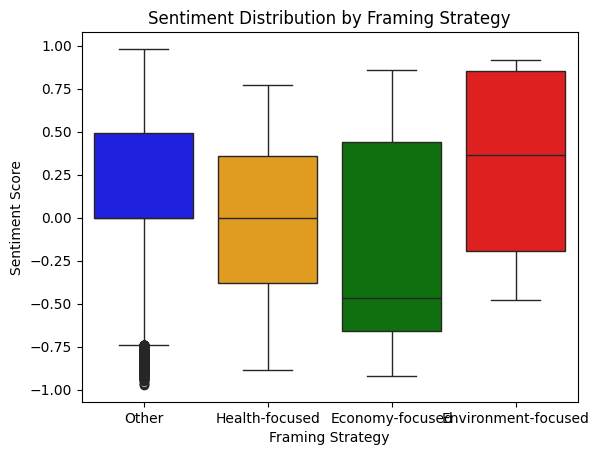

In [ ]:
def identify_framing_strategy(text):
    # Define a list of keywords or phrases associated with each framing strategy
    economy_keywords = ['economy', 'economic growth', 'unemployment', 'jobs', 'GDP']
    health_keywords = ['health', 'pandemic', 'COVID-19', 'vaccine', 'public health']
    environment_keywords = ['environment', 'climate change', 'global warming', 'sustainability', 'carbon emissions']

    # Convert text to lowercase and tokenize
    tokens = word_tokenize(text.lower())

    # Check for the presence of keywords associated with each framing strategy
    if any(keyword in tokens for keyword in economy_keywords):
        return 'Economy-focused'
    elif any(keyword in tokens for keyword in health_keywords):
        return 'Health-focused'
    elif any(keyword in tokens for keyword in environment_keywords):
        return 'Environment-focused'
    else:
        return 'Other'
color_palette = {"Economy-focused": "green", "Health-focused": "orange", "Environment-focused": "red", "Other": "blue"}

# Apply framing analysis to preprocessed text
twitter_data['framing_strategy'] = twitter_data['preprocessed_text'].apply(identify_framing_strategy)

# Visualize the relationship between sentiment scores and framing strategies
sns.boxplot(x='framing_strategy', y='sentiment_score', data=twitter_data, palette=color_palette)
plt.xlabel('Framing Strategy')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Distribution by Framing Strategy')
plt.show()

In [ ]:
twitter_data.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)', 'preprocessed_text', 'sentiment_score',
       'framing_strategy'],
      dtype='object')

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   textID             31015 non-null  object 
 1   text               31014 non-null  object 
 2   selected_text      27480 non-null  object 
 3   sentiment          31015 non-null  object 
 4   Time of Tweet      31015 non-null  object 
 5   Age of User        31015 non-null  object 
 6   Country            31015 non-null  object 
 7   Population -2020   31015 non-null  float64
 8   Land Area (Km²)    31015 non-null  float64
 9   Density (P/Km²)    31015 non-null  float64
 10  preprocessed_text  32296 non-null  object 
 11  sentiment_score    32296 non-null  float64
 12  framing_strategy   32296 non-null  object 
dtypes: float64(4), object(9)
memory usage: 3.4+ MB


In [ ]:
import re

# Function to remove unnecessary characters from text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', str(text))
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    # Replace multiple whitespaces with single whitespace
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text

# Apply the clean_text function to clean the text in the DataFrame
combined_df['cleaned_text'] = combined_df['text'].apply(clean_text)

In [ ]:
# Function to tokenize text
def tokenize_text(text):
    try:
        # Convert text to string
        text = str(text)
        # Tokenize the text
        tokens = word_tokenize(text)
        return tokens
    except Exception as e:
        # Print error message if tokenization fails
        print(f"Error tokenizing text: {e}")
        return []

# Apply the tokenize_text function to tokenize the text in the DataFrame
combined_df['tokenized_text'] = combined_df['text'].apply(tokenize_text)

In [ ]:
#Normalization
def normalize_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text
combined_df['normalized_text'] = combined_df['text'].apply(normalize_text)

In [ ]:
from nltk.corpus import stopwords

# Function to remove stopwords from text
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
        filtered_text = ' '.join(filtered_words)
    else:
        filtered_text = ''
    return filtered_text

# Apply the remove_stopwords function to the text in the DataFrame
combined_df['cleaned_text_no_stopwords'] = combined_df['text'].apply(remove_stopwords)

In [ ]:
#Removing Missing Values
combined_df.dropna(inplace=True)

In [ ]:
combined_df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

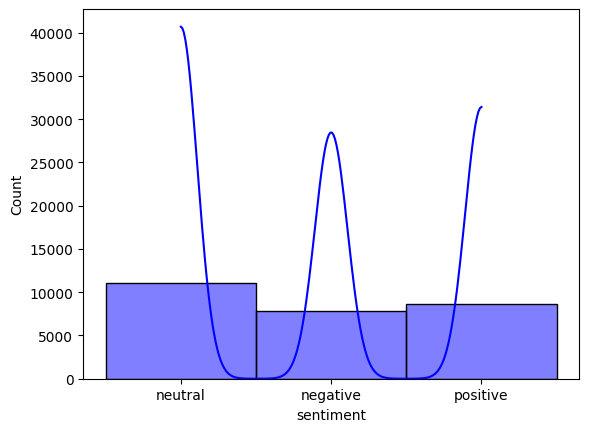

In [ ]:
sns.histplot(combined_df['sentiment'], kde=True, color = 'b')
plt.show()

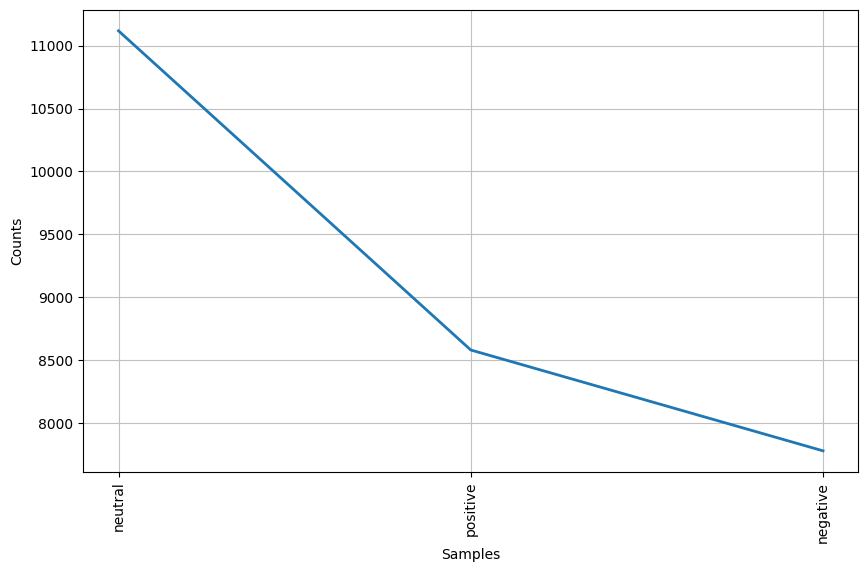

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
#Word Frequency Distribution
from nltk.probability import FreqDist

word_freq = FreqDist(word_tokenize(' '.join(combined_df['sentiment'])))
plt.figure(figsize=(10, 6))
word_freq.plot(20, cumulative=False)

In [ ]:
# Define the list of stopwords and punctuation to be removed
stopwords_to_remove = list(stopwords.words('english'))
punctuation_to_remove = list(punctuation)
stuff_to_be_removed = stopwords_to_remove + punctuation_to_remove

# Instantiate LancasterStemmer
stemmer = LancasterStemmer()

# Extract the text corpus from the DataFrame
corpus = combined_df['text'].tolist()

In [ ]:
final_corpus = combined_df['text'].astype(str).tolist()
eda_data = pd.DataFrame()
eda_data['text'] = final_corpus
eda_data['sentiment'] = combined_df["sentiment"].values
eda_data.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
# Convert 'Time of Tweet' to categorical codes
combined_df['Time_of_Tweet_code'] = combined_df['Time of Tweet'].astype('category').cat.codes

# Convert 'Country' to categorical codes
combined_df['Country_code'] = combined_df['Country'].astype('category').cat.codes

# Map 'Age of User' to numerical values
age_mapping = {'0-20': 18, '21-30': 25, '31-45': 38, '46-60': 53, '60-70': 65, '70-100': 80}
combined_df['Age_of_User'] = combined_df['Age of User'].replace(age_mapping)

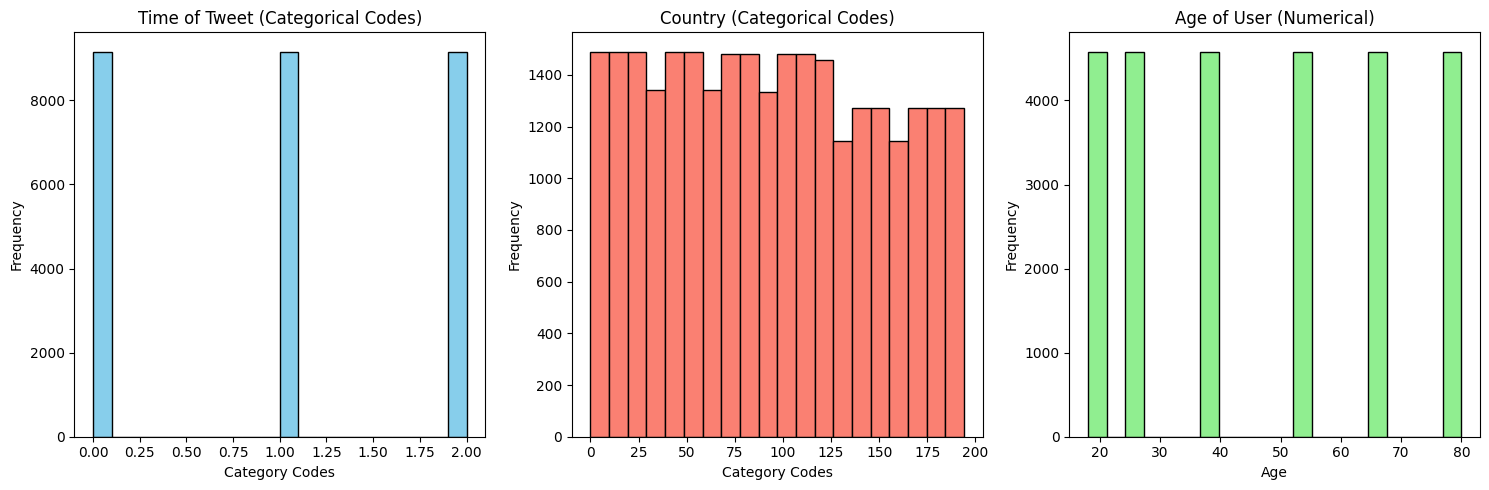

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot 'Time of Tweet' column
axes[0].hist(combined_df['Time_of_Tweet_code'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Time of Tweet (Categorical Codes)')
axes[0].set_xlabel('Category Codes')
axes[0].set_ylabel('Frequency')

# Plot 'Country' column
axes[1].hist(combined_df['Country_code'], bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Country (Categorical Codes)')
axes[1].set_xlabel('Category Codes')
axes[1].set_ylabel('Frequency')

# Plot 'Age of User' column
axes[2].hist(combined_df['Age_of_User'], bins=20, color='lightgreen', edgecolor='black')
axes[2].set_title('Age of User (Numerical)')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Remove specified columns from the DataFrame
combined_df = combined_df.drop(columns=['textID', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

In [ ]:
import string
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Remove newline characters
    text = re.sub(r'\n', '', text)
    # Remove words containing digits
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Apply the clean_text function to clean the 'selected_text' column in the DataFrame
combined_df['selected_text'] = combined_df['selected_text'].apply(clean_text)


In [ ]:
x=combined_df['selected_text']
y= combined_df['sentiment']

In [ ]:
x[0]

'Id have responded if I were going'

In [ ]:
from collections import Counter
Counter(y)

Counter({'neutral': 11117, 'negative': 7781, 'positive': 8582})

In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

# Instantiate RandomUnderSampler
undersampler = RandomUnderSampler()

# Reshape y if necessary (required by RandomUnderSampler)
y_reshaped = y.values.reshape(-1, 1)

# Perform undersampling
X_resampled, y_resampled = undersampler.fit_resample(x.values.reshape(-1, 1), y_reshaped)

# Convert y_resampled back to a 1D array
y_resampled = y_resampled.ravel()

# Convert X_resampled to a pandas Series with the same index as X
X_resampled = pd.Series(X_resampled.ravel(), index=x.index[:len(X_resampled)])

# Now X_resampled and y_resampled contain the undersampled data


In [ ]:
Counter(y_resampled)

Counter({'negative': 7781, 'neutral': 7781, 'positive': 7781})

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size=0.1,random_state=42,stratify=y_resampled)

In [ ]:
Counter(y_train)

Counter({'positive': 7002, 'neutral': 7003, 'negative': 7003})

In [ ]:
Counter(y_test)

Counter({'negative': 778, 'neutral': 778, 'positive': 779})

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
X_train_vector = vectorization.fit_transform(X_train)
X_test_vector = vectorization.transform(X_test)

In [ ]:
#testing accuracy of logistic regression

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(n_jobs=-1)
lr.fit(X_train_vector,y_train)
lr.score(X_test_vector,y_test)


0.8342612419700214

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder


# Train XGBClassifier
label_encoder = LabelEncoder()
y_train_xg_boost = label_encoder.fit_transform(y_train)
y_test_xg_boost = label_encoder.transform(y_test)


xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_vector,y_train_xg_boost)
xgboost_model.score(X_test_vector,y_test_xg_boost)


0.798286937901499

In [ ]:
# Train AdaBoostClassifier
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train_vector,y_train_xg_boost)
adaboost_model.score(X_test_vector,y_test_xg_boost)

0.6907922912205567

In [ ]:
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()

XV_train_dense = X_train_vector.toarray()
XV_train_dense = XV_train_dense.reshape(XV_train_dense.shape[0],XV_train_dense.shape[1],1)
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_one_hot = to_categorical(y_train_encoded)


XV_test_dense = X_test_vector.toarray()
XV_test_dense = XV_test_dense.reshape(XV_test_dense.shape[0],XV_test_dense.shape[1],1)
y_test_encoded = label_encoder.transform(y_test)
y_test_one_hot = to_categorical(y_test_encoded)

In [ ]:
XV_train_dense.shape

(21008, 13981, 1)

In [ ]:
n_timesteps, n_features, n_outputs = XV_train_dense.shape[1],XV_train_dense.shape[2],y_test_one_hot.shape[1]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2,))

model.add(LSTM(16, return_sequences = True))

model.add(Flatten())
# Additional Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13980, 64)         192       
                                                                 
 conv1d_1 (Conv1D)           (None, 13979, 32)         4128      
                                                                 
 max_pooling1d (MaxPooling1  (None, 6989, 32)          0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 6989, 16)          3136      
                                                                 
 flatten (Flatten)           (None, 111824)            0         
                                                                 
 dense (Dense)               (None, 128)               14313600  
                                                        

In [ ]:
optimizer_adam =tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath where the best model will be saved
checkpoint_filepath = '/kaggle/working/best_model.keras'

# Define the ModelCheckpoint callback to monitor validation accuracy and save the best model
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
# Train the model with the added callback
history = model.fit(
    XV_train_dense,
    y_train_one_hot,
    epochs=5,
    batch_size=64,
    validation_data=(XV_test_dense, y_test_one_hot),
    callbacks=[model_checkpoint_callback]  # Pass the callback to the fit method
)

Epoch 1/5
329/329 [==============================] - 87s 240ms/step - loss: 0.6391 - accuracy: 0.7167 - val_loss: 0.4393 - val_accuracy: 0.8343
Epoch 2/5
329/329 [==============================] - 78s 236ms/step - loss: 0.3600 - accuracy: 0.8647 - val_loss: 0.4344 - val_accuracy: 0.8334
Epoch 3/5
329/329 [==============================] - 93s 283ms/step - loss: 0.1905 - accuracy: 0.9331 - val_loss: 0.5080 - val_accuracy: 0.8321
Epoch 4/5
329/329 [==============================] - 80s 242ms/step - loss: 0.0812 - accuracy: 0.9758 - val_loss: 0.6789 - val_accuracy: 0.8167
Epoch 5/5
329/329 [==============================] - 80s 242ms/step - loss: 0.0423 - accuracy: 0.9880 - val_loss: 0.8294 - val_accuracy: 0.8231


In [ ]:
y_pred_classes = model.predict(XV_test_dense)
y_pred  = np.argmax(y_pred_classes,axis=1)

73/73 [==============================] - 7s 83ms/step


In [ ]:
y_true = np.argmax(y_test_one_hot,axis=-1)

In [ ]:
import tensorflow as tf

# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
Counter(y_pred)

Counter({0: 743, 1: 881, 2: 711})

In [ ]:
Counter(y_true)

Counter({0: 778, 1: 778, 2: 779})

In [ ]:
from sklearn.metrics import classification_report, f1_score,precision_score,recall_score,accuracy_score
import seaborn as sns

# calculate the F1-score, precision, and recall
f1score = f1_score(y_true, y_pred,average='weighted')
precision = precision_score(y_true, y_pred,average='weighted')
recall = recall_score(y_true, y_pred,average='weighted')
accuracy = accuracy_score(y_true,y_pred)

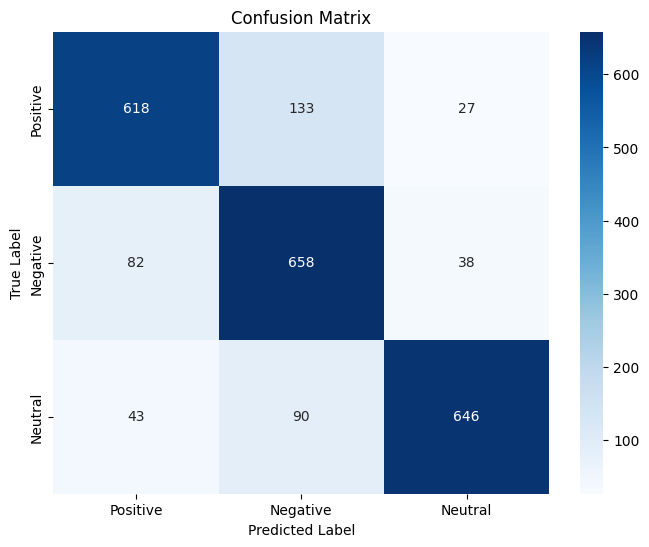

In [ ]:
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, cmap="Blues", annot=True, fmt="d", xticklabels=["Positive",'Negative','Neutral'],
            yticklabels=["Positive",'Negative','Neutral'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('heatmap.png')
plt.show()

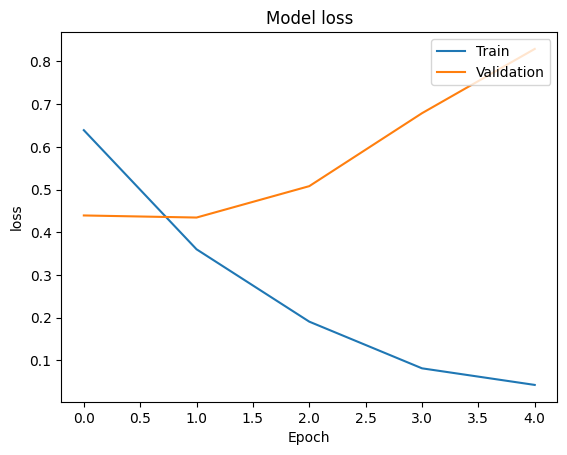

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Loss.png')
plt.show()

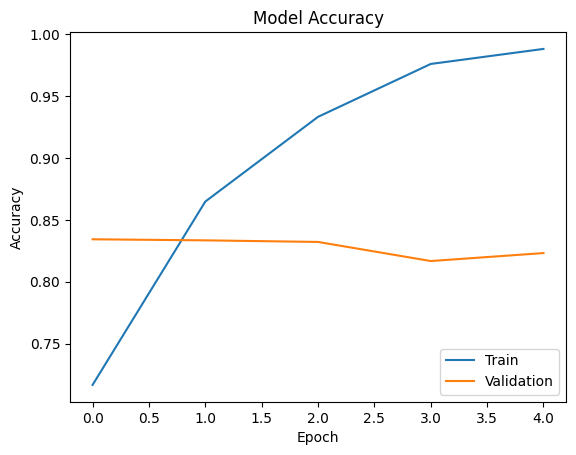

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Accuracy.png')
plt.show()

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv1D, MaxPooling1D, LSTM

# Load the dataset and preprocess it
# ...

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42, stratify=y_resampled)

# Vectorize the text data
vectorization = TfidfVectorizer()
X_train_vector = vectorization.fit_transform(X_train)
X_test_vector = vectorization.transform(X_test)

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32), kernel_size=2, activation='relu', input_shape=(X_train_vector.shape[1], 1)))
    model.add(Conv1D(filters=hp.Int('conv2_filters', min_value=16, max_value=64, step=16), kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(hp.Int('lstm_units', min_value=8, max_value=32, step=8), return_sequences=True))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='sentiment_analysis'
)

# Search for the best hyperparameters
tuner.search(X_train_vector.toarray().reshape(X_train_vector.shape[0], X_train_vector.shape[1], 1), y_train_encoded, epochs=5, validation_data=(X_test_vector.toarray().reshape(X_test_vector.shape[0], X_test_vector.shape[1], 1), y_test_encoded))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
test_accuracy = best_model.evaluate(X_test_vector.toarray().reshape(X_test_vector.shape[0], X_test_vector.shape[1], 1), y_test_encoded)[1]
print("Test Accuracy:", test_accuracy)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42, stratify=y_resampled)

# Vectorize the text data
vectorization = TfidfVectorizer()
X_train_vector = vectorization.fit_transform(X_train)
X_test_vector = vectorization.transform(X_test)

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32), kernel_size=2, activation='relu', input_shape=(X_train_vector.shape[1], 1)))
    model.add(Conv1D(filters=hp.Int('conv2_filters', min_value=16, max_value=64, step=16), kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(hp.Int('lstm_units', min_value=8, max_value=32, step=8), return_sequences=True))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='sentiment_analysis'
)

# Search for the best hyperparameters
tuner.search(X_train_vector.toarray().reshape(X_train_vector.shape[0], X_train_vector.shape[1], 1), y_train_encoded, epochs=5, validation_data=(X_test_vector.toarray().reshape(X_test_vector.shape[0], X_test_vector.shape[1], 1), y_test_encoded))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
test_accuracy = best_model.evaluate(X_test_vector.toarray().reshape(X_test_vector.shape[0], X_test_vector.shape[1], 1), y_test_encoded)[1]
print("Test Accuracy:", test_accuracy)


Trial 5 Complete [00h 12m 30s]
val_accuracy: 0.8376873731613159

Best val_accuracy So Far: 0.8462526798248291
Total elapsed time: 01h 05m 21s
73/73 [==============================] - 9s 100ms/step - loss: 0.4267 - accuracy: 0.8463
Test Accuracy: 0.8462526798248291
Reloading Tuner from tuner_dir/sentiment_analysis/tuner0.json
73/73 [==============================] - 9s 102ms/step - loss: 0.4267 - accuracy: 0.8463
Test Accuracy: 0.8462526798248291


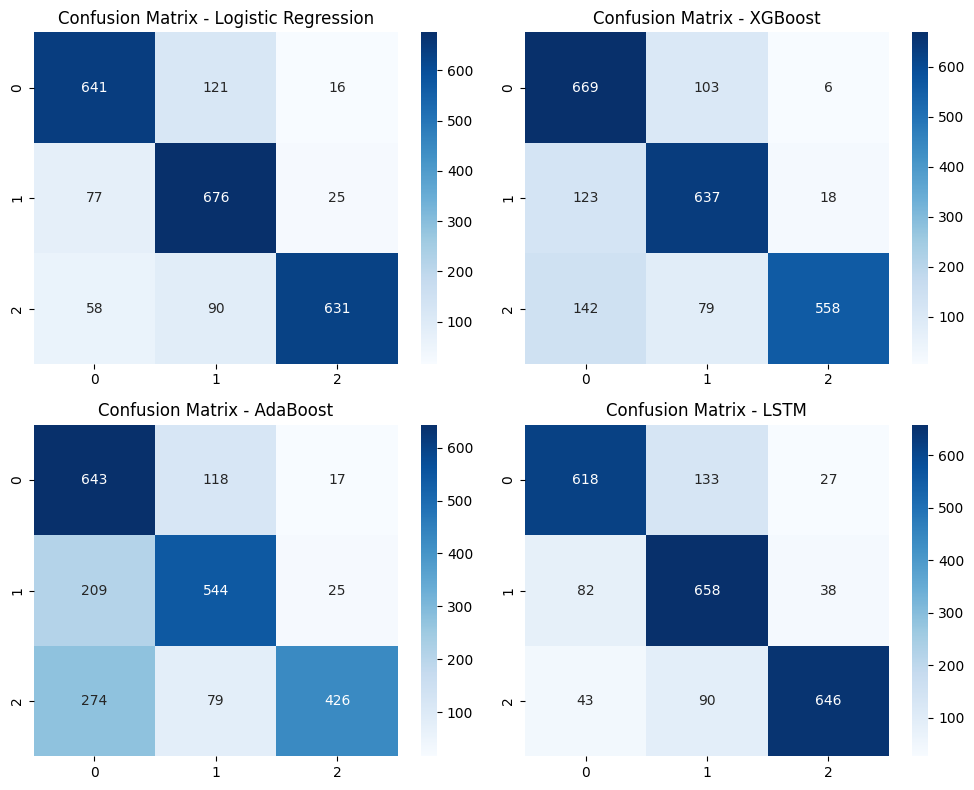

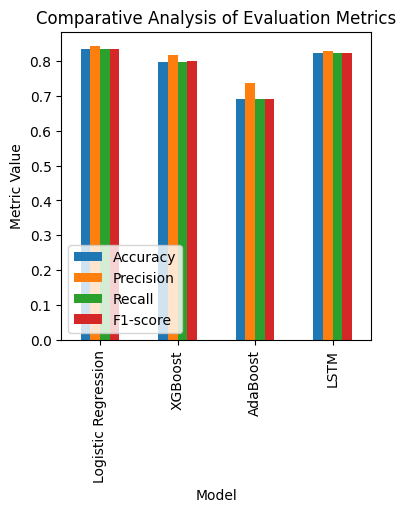

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a dictionary to store evaluation metrics for each model
evaluation_results = {}

# Define a function to evaluate a model and store the results in the dictionary
def evaluate_model(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    confusion_mat = confusion_matrix(y_true, y_pred)

    evaluation_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Confusion Matrix': confusion_mat
    }

# Evaluate each model and store the results
evaluate_model('Logistic Regression', y_test, lr.predict(X_test_vector))
evaluate_model('XGBoost', y_test_xg_boost, xgboost_model.predict(X_test_vector))
evaluate_model('AdaBoost', y_test_xg_boost, adaboost_model.predict(X_test_vector))
evaluate_model('LSTM', y_test_encoded, y_pred)

# Plot comparative analysis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i, (model_name, metrics) in enumerate(evaluation_results.items()):
    row = i // 2
    col = i % 2
    sns.heatmap(metrics['Confusion Matrix'], cmap="Blues", annot=True, fmt="d", ax=axes[row, col])
    axes[row, col].set_title(f'Confusion Matrix - {model_name}')

plt.tight_layout()
plt.show()

# Plot comparative analysis for other evaluation metrics
metrics_df = pd.DataFrame(evaluation_results).transpose()
metrics_df.plot(kind='bar', figsize=(4, 4))
plt.title('Comparative Analysis of Evaluation Metrics')
plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.xticks(rotation=90)
plt.legend(loc='lower left')
plt.show()
